In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
report_data = pd.read_csv('report_data.csv', delimiter=';')
report_data

,№,Дата ответа,"Так как опрос анонимный, расскажите немного о себе. Это поможет нам сформировать портрет пользователя.",Ваш пол:,Ваш возраст:,Ваше образование:,Выберите ваш дивизион:,Укажите название вашего предприятия:,"Продолжите фразу: ""Я...""",Укажите ваш уровень должности:,...,"Где, на ваш взгляд, должны располагаться проверочные задания в электронном курсе?",Какое обучение для вас является практичным? \nВыберите все подходящие утверждения:,Обучение в РЕКОРД mobile помогает вам решать рабочие задачи?,"Выберите варианты ответа, которые считаете верными:",Какие комментарии и пожелания по качеству электронного обучения в РЕКОРД mobile у вас есть? \nЧто вы хотели бы улучшить? Изменить? Добавить?,"И последний блок вопросов. Мы знаем, что сотрудники отрасли также обучаются вне отрасли. Если вы проходите электронное обучение на внешних площадках, расскажите о своем опыте.",Проходите ли вы электронное обучение вне отрасли?,"Выберите причины, по которым вы проходите электронное обучение на внешних ресурсах:",Где именно вы обучаетесь вне отрасли?,По каким тематическим направлениям вы обучаетесь?
0,12,19.09.2022,Хорошо,Мужской,25–29 лет,Среднее специальное,Аварийная готовность и специальные перевозки,Илл,Научный сотрудник,Линейный руководитель (при наличии только прям...,...,В каждом разделе на протяжении изучения всего ...,"Где есть связь с жизнью и понятно, что, как и ...",Полностью согласен,Я никогда не конспектирую во время обучения,Илл,Нет ответа,Нет,Нет ответа,Нет ответа,Нет ответа
1,13,19.09.2022,Хорошо,Мужской,36–44 года,Высшее,Экологические решения,"ФГУП ""РАДОН""",Сотрудник производства,Линейный руководитель (при наличии только прям...,...,В каждом разделе на протяжении изучения всего ...,"Где есть практические задания для отработки, Г...",Скорее согласен,"Я делаю скриншоты вместо конспекта, Я никогда ...",Затрудняюсь ответить,Хорошо,Нет,Нет ответа,Нет ответа,Нет ответа
2,14,19.09.2022,Хорошо,Мужской,30–35 лет,Высшее,Электроэнергетический,Кольская АЭС,Сотрудник производства,Руководитель среднего уровня (при наличии руко...,...,В конце каждого раздела,"Где есть примеры из различных ситуаций, Где ес...",Скорее согласен,"Если есть памятки на скачивание, я не конспект...",На данном этапе все устраивает.,Хорошо,Нет,Нет ответа,Нет ответа,Нет ответа
3,15,19.09.2022,Хорошо,Женский,45–54 года,Высшее,Ядерный оружейный комплекс,ГХК,Сотрудник офиса,Рабочий/служащий,...,В конце каждого раздела,"Где есть практические задания для отработки, Г...",Скорее согласен,Я никогда не использую рабочие тетради,комментариев нет,Нет ответа,Нет,Нет ответа,Нет ответа,Нет ответа
4,16,19.09.2022,Хорошо,Мужской,45–54 года,Высшее,Ядерный оружейный комплекс,Элерон,Научный сотрудник,Специалист/научный или технический работник,...,В конце каждого раздела,"Где есть примеры из моей сферы деятельности, Г...",Скорее согласен,"Если есть памятки на скачивание, я не конспект...",Добавить примеры из реальной деятельности,Нет ответа,Нет,Нет ответа,Нет ответа,Нет ответа
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2766,2778,04.10.2022,Хорошо,Женский,36–44 года,Среднее специальное,АСУТП и электротехника,"АО ""РАСУ""",Сотрудник офиса,Специалист/научный или технический работник,...,Нет ответа,Нет ответа,Нет ответа,Нет ответа,Нет ответа,Нет ответа,Нет ответа,Нет ответа,Нет ответа,Нет ответа
2767,2779,04.10.2022,Хорошо,Мужской,36–44 года,Высшее,Электроэнергетический,Белоярская АЭС,Сотрудник производства,Рабочий/служащий,...,Нет ответа,Нет ответа,Нет ответа,Нет ответа,Нет ответа,Нет ответа,Нет ответа,Нет ответа,Нет ответа,Нет ответа
2768,2780,04.10.2022,Нет ответа,Женский,45–54 года,Среднее специальное,Ядерный оружейный комплекс,"АО ""НИКИЭТ""",Сотрудник офиса,Специалист/научный или технический работник,...,Нет ответа,Нет ответа,Нет ответа,Нет ответа,Нет ответа,Нет ответа,Нет ответа,Нет ответа,Нет ответа,Нет ответа
2769,2781,04.10.2022,Хорошо,Женский,25–29 лет,Высшее,Наука и инновации,АО ГНЦ РФ ТРИНИТИ,Сотрудник производства,Линей

In [6]:
df = report_data.copy()
df = df.replace('Нет ответа', np.nan)
df

,№,Дата ответа,"Так как опрос анонимный, расскажите немного о себе. Это поможет нам сформировать портрет пользователя.",Ваш пол:,Ваш возраст:,Ваше образование:,Выберите ваш дивизион:,Укажите название вашего предприятия:,"Продолжите фразу: ""Я...""",Укажите ваш уровень должности:,...,"Где, на ваш взгляд, должны располагаться проверочные задания в электронном курсе?",Какое обучение для вас является практичным? \nВыберите все подходящие утверждения:,Обучение в РЕКОРД mobile помогает вам решать рабочие задачи?,"Выберите варианты ответа, которые считаете верными:",Какие комментарии и пожелания по качеству электронного обучения в РЕКОРД mobile у вас есть? \nЧто вы хотели бы улучшить? Изменить? Добавить?,"И последний блок вопросов. Мы знаем, что сотрудники отрасли также обучаются вне отрасли. Если вы проходите электронное обучение на внешних площадках, расскажите о своем опыте.",Проходите ли вы электронное обучение вне отрасли?,"Выберите причины, по которым вы проходите электронное обучение на внешних ресурсах:",Где именно вы обучаетесь вне отрасли?,По каким тематическим направлениям вы обучаетесь?
0,12,19.09.2022,Хорошо,Мужской,25–29 лет,Среднее специальное,Аварийная готовность и специальные перевозки,Илл,Научный сотрудник,Линейный руководитель (при наличии только прям...,...,В каждом разделе на протяжении изучения всего ...,"Где есть связь с жизнью и понятно, что, как и ...",Полностью согласен,Я никогда не конспектирую во время обучения,Илл,NaN,Нет,NaN,NaN,NaN
1,13,19.09.2022,Хорошо,Мужской,36–44 года,Высшее,Экологические решения,"ФГУП ""РАДОН""",Сотрудник производства,Линейный руководитель (при наличии только прям...,...,В каждом разделе на протяжении изучения всего ...,"Где есть практические задания для отработки, Г...",Скорее согласен,"Я делаю скриншоты вместо конспекта, Я никогда ...",Затрудняюсь ответить,Хорошо,Нет,NaN,NaN,NaN
2,14,19.09.2022,Хорошо,Мужской,30–35 лет,Высшее,Электроэнергетический,Кольская АЭС,Сотрудник производства,Руководитель среднего уровня (при наличии руко...,...,В конце каждого раздела,"Где есть примеры из различных ситуаций, Где ес...",Скорее согласен,"Если есть памятки на скачивание, я не конспект...",На данном этапе все устраивает.,Хорошо,Нет,NaN,NaN,NaN
3,15,19.09.2022,Хорошо,Женский,45–54 года,Высшее,Ядерный оружейный комплекс,ГХК,Сотрудник офиса,Рабочий/служащий,...,В конце каждого раздела,"Где есть практические задания для отработки, Г...",Скорее согласен,Я никогда не использую рабочие тетради,комментариев нет,NaN,Нет,NaN,NaN,NaN
4,16,19.09.2022,Хорошо,Мужской,45–54 года,Высшее,Ядерный оружейный комплекс,Элерон,Научный сотрудник,Специалист/научный или технический работник,...,В конце каждого раздела,"Где есть примеры из моей сферы деятельности, Г...",Скорее согласен,"Если есть памятки на скачивание, я не конспект...",Добавить примеры из реальной деятельности,NaN,Нет,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2766,2778,04.10.2022,Хорошо,Женский,36–44 года,Среднее специальное,АСУТП и электротехника,"АО ""РАСУ""",Сотрудник офиса,Специалист/научный или технический работник,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2767,2779,04.10.2022,Хорошо,Мужской,36–44 года,Высшее,Электроэнергетический,Белоярская АЭС,Сотрудник производства,Рабочий/служащий,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2768,2780,04.10.2022,NaN,Женский,45–54 года,Среднее специальное,Ядерный оружейный комплекс,"АО ""НИКИЭТ""",Сотрудник офиса,Специалист/научный или технический работник,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2769,2781,04.10.2022,Хорошо,Женский,25–29 лет,Высшее,Наука и инновации,АО ГНЦ РФ ТРИНИТИ,Сотрудник производства,Линейный руководитель (при наличии только прям...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
df[df.columns[4]].value_counts()

36–44 года                          1043
30–35 лет                            574
45–54 года                           571
25–29 лет                            235
55 лет и старше                      230
До 25 лет                             93
36–44 года, 36–44 года                 4
30–35 лет, 30–35 лет                   3
25–29 лет, 25–29 лет                   3
55 лет и старше, 55 лет и старше       2
45–54 года, 45–54 года                 1
Name: Ваш возраст:, dtype: int64

In [56]:
categories = df[df.columns[4]].value_counts()
categories = categories.where(lambda x: x < 20).dropna().index.unique()
categories

CategoricalIndex([], categories=['25–29 лет', '30–35 лет', '36–44 года', '45–54 года', '55 лет и старше', 'До 25 лет'], ordered=False, dtype='category')

In [57]:
df[df.columns[4]] = df[df.columns[4]].astype('category').cat.remove_categories(categories)
test = df[df.columns[4]].value_counts()

In [78]:
sns.set(rc={'figure.figsize':(12,12)})

def clean_unnecessary(df):
    for column in df.columns:
        categories = df[column].value_counts()
        categories = categories.where(lambda x: x < 20).dropna().index.unique()
        df[column] = df[column].astype('category').cat.remove_categories(categories)
    return df


def visualize(df):
    # visualize sex distirbution
    fig, ax = plt.subplots(3, 1)
    sns.countplot(x=df[df.columns[3]], ax=ax[0])

    # visualize age distribution
    sns.countplot(x=df[df.columns[4]], ax=ax[1])

    # visualize education distribution
    sns.countplot(x=df[df.columns[5]], ax=ax[2])
    fig.show()

C:\Users\mtank\AppData\Local\Temp\ipykernel_13764\4075823596.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].astype('category').cat.remove_categories(categories)
C:\Users\mtank\AppData\Local\Temp\ipykernel_13764\4075823596.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].astype('category').cat.remove_categories(categories)
C:\Users\mtank\AppData\Local\Temp\ipykernel_13764\4075823596.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of

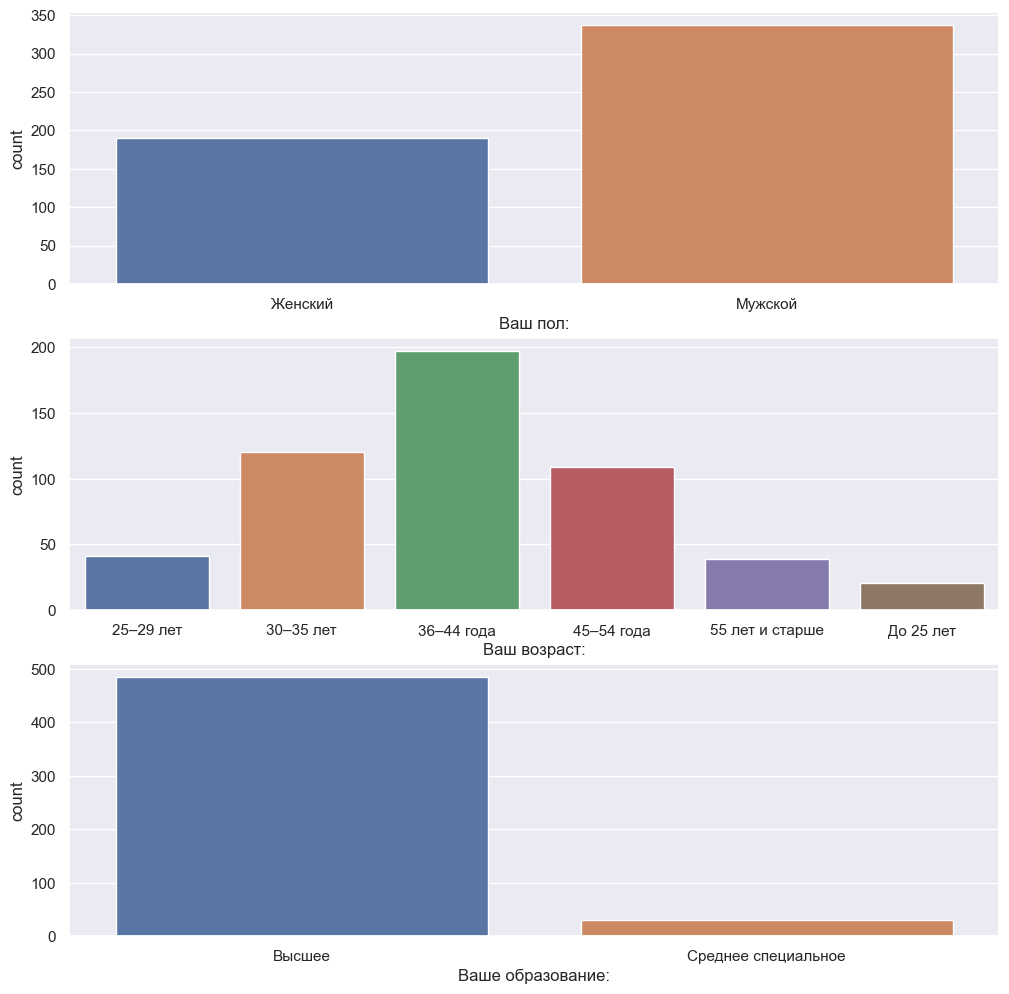

In [99]:
df_filt = df[df[df.columns[6]] == 'Электроэнергетический']
visualize(clean_unnecessary(df_filt))

In [125]:
# 2nd hypothesis
q1 = 'Сколько времени на обучение в среднем в неделю вы готовы выделять?'
q2 = 'Когда чаще всего вы проходите обучение, назначенное HR/в системе РЕКОРД?'
q3 = 'Представьте, что у вас есть возможность всегда выбирать, в каком формате проходить обучение в РЕКОРД mobile.'

cmns = [df.columns[x] for x in [3, 4, 5, 6, 7, 8, 9]]
cmns.extend([q1,q2,q3])
df_2 = df.copy()[cmns]
df_2

,Ваш пол:,Ваш возраст:,Ваше образование:,Выберите ваш дивизион:,Укажите название вашего предприятия:,"Продолжите фразу: ""Я...""",Укажите ваш уровень должности:,Сколько времени на обучение в среднем в неделю вы готовы выделять?,"Когда чаще всего вы проходите обучение, назначенное HR/в системе РЕКОРД?","Представьте, что у вас есть возможность всегда выбирать, в каком формате проходить обучение в РЕКОРД mobile."
0,Мужской,25–29 лет,Среднее специальное,Аварийная готовность и специальные перевозки,Илл,Научный сотрудник,Линейный руководитель (при наличии только прям...,От 30 минут до 1 часа,В обеденный перерыв,"1.Электронный курс (интерактивный формат, соде..."
1,Мужской,36–44 года,Высшее,Экологические решения,"ФГУП ""РАДОН""",Сотрудник производства,Линейный руководитель (при наличии только прям...,От 30 минут до 1 часа,В обеденный перерыв,"1.Электронный курс (интерактивный формат, соде..."
2,Мужской,30–35 лет,Высшее,Электроэнергетический,Кольская АЭС,Сотрудник производства,Руководитель среднего уровня (при наличии руко...,Более 2-х часов,По вечерам/на выходных/в отпуске,1.Тексты; 2.Аудио-подкаст; 3.Запись спикера в ...
3,Женский,45–54 года,Высшее,Ядерный оружейный комплекс,ГХК,Сотрудник офиса,Рабочий/служащий,Нет возможности выделять время каждую неделю,В обеденный перерыв,"1.Электронный курс (интерактивный формат, соде..."
4,Мужской,45–54 года,Высшее,Ядерный оружейный комплекс,Элерон,Научный сотрудник,Специалист/научный или технический работник,От 30 минут до 1 часа,В обеденный перерыв,"1.Электронный курс (интерактивный формат, соде..."
...,...,...,...,...,...,...,...,...,...,...
2766,Женский,36–44 года,Среднее специальное,АСУТП и электротехника,"АО ""РАСУ""",Сотрудник офиса,Специалист/научный или технический работник,От 1 часа до 2-х часов,В обеденный перерыв,"1.Электронный курс (интерактивный формат, соде..."
2767,Мужской,36–44 года,Высшее,Электроэнергетический,Белоярская АЭС,Сотрудник производства,Рабочий/служащий,От 1 часа до 2-х часов,В обеденный перерыв,1.Аудио-подкаст; 2.Запись спикера в студии; 3....
2768,Женский,45–54 года,Среднее специальное,Ядерный оружейный комплекс,"АО ""НИКИЭТ""",Сотрудник офиса,Специалист/научный или технический работник,NaN,NaN,NaN
2769,Женский,25–29 лет,Высшее,Наука и инновации,АО ГНЦ РФ ТРИНИТИ,Сотрудник производства,Линейный руководитель (при наличии только прям...,NaN,NaN,1.Запись экрана (скринкаст); 2.Аудио-подкаст; ...
